#### TODO:
- Algo seems to only be off by $100, but that's not much in the crypto world.
- Need to figure out how to make this more useful. 
- Next price point isn't bad, but what's the start? I can make a decent model. Now what?
    - Figure out how to generate the same data, but now estimate it for the next day.

# Use lagged values to predict current price to forecast price
- Notes from this video: https://www.youtube.com/watch?v=xaIA83x5Icg
 - Create separate transformers for features on different scales
 - Use this video for building an initial LSTM model
- Use this video and it's subsequent one for time series forecasting for BTC using binance exchange data: https://www.youtube.com/watch?v=jR0phoeXjrc
    - Use shift to push a column down for matching previous data points to a forecasted point.
    - This video is showing how to prep data for a time series model.
    - This video is for how to take that preprocessed data and put into PyTorch for the LSTM model: https://www.youtube.com/watch?v=ODEGJ_kh2aA&t=107s
         - 

### TODO:
- Now that I'm able to forecast, I need to generate multiple models, and get the mean of all of their estimations a'la a random walk
- Now plot the number of different estimations in the future to get a general sense of the forecasting.

In [3372]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import os

In [3373]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse

In [3374]:
import datetime

In [3375]:
import tensorflow as tf
from keras import layers

In [3376]:
from keras import models

In [3377]:
from keras import optimizers

In [3391]:
def train_models(df, label,training_cols, time_steps):
    scaler = StandardScaler()
#     df[label] = scaler.fit_transform(df[[label]])
#     for col in training_cols:
#         df[col] = scaler.transform(df[[col]])
    X = df[training_cols].values
    y = df[label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
    output = compare_rg(X_train, y_train, X_test, y_test, time_steps)
    return output, scaler

In [3392]:
def compare_rg(X_train, y_train, X_test, y_test, time_steps):
    classifiers = {
        'XGBR': XGBRegressor(),
#         'NN': neural_net(X_train.shape, time_steps)
    }

    outputs = {
        'XGBR': [],
#         'NN': []
    }
    for model in classifiers:
        if model == 'NN':            
            algo = classifiers[model]
            X_train, y_train = create_dataset(X_train, y_train, time_steps)
            X_test, y_test = create_dataset(X_test, y_test, time_steps)
            algo.fit(X_train, y_train, X_test, y_test)
        else:
            algo = classifiers[model]
            algo.fit(X_train, y_train)
            y_predict = algo.predict(X_test)
#             print(" ")
#             print(model, ': ',mse(y_test, y_predict))
        for output in outputs:
            if output == model:
                outputs[output] = algo
#         print('')
    return outputs

In [3393]:
#https://machinelearningmastery.com/use-features-lstm-networks-time-series-forecasting/
# https://www.kdnuggets.com/2018/11/keras-long-short-term-memory-lstm-model-predict-stock-prices.html
class neural_net:
    def __init__(self, shape_input, time_steps):
        self.shape_input = shape_input
        self.model = models.Sequential()
        self.batch_size = 32
        self.model.add(layers.Bidirectional(
            layers.LSTM(units=8, input_shape=(time_steps, shape_input[1]), return_sequences=False)
        ))
        self.model.add(layers.Dropout(0.2, name='dropout_0'))
        self.model.add(layers.Dense(4, activation='relu'))
        self.model.add(layers.Dense(1, activation='relu'))
        self.model.compile(optimizer='adam', loss='mean_squared_error')
#         print(self.model.summary())

    
    def fit(self, X_train, y_train, X_test, y_test):
        self.model.fit(x=X_train, y=y_train, batch_size = self.batch_size, epochs=50, shuffle=False, validation_split=0.1)
        evaluation = self.model.evaluate(X_test, y_test)
        print(evaluation)
    
    def predict(self, Xnew):
        yNew = self.model.predict_classes(Xnew)
        return yNew

In [3394]:
def create_dataset(X, y, time_steps = 20):
    y = y.values
    Xs, ys = [] , []
    for i in range(len(X) - time_steps):
        v = X[i: (i+time_steps)]
        Xs.append(v)
        ys.append(y[(i+time_steps)])
    return np.array(Xs), np.array(ys)

In [3382]:
future_estim = 5
output_label = 'next_close_'+str(future_estim)

In [3395]:
NUM_MODELS = 100

In [3384]:
window_size = 20

In [3379]:
crypto = pd.read_csv('ETH-USD.csv')

In [3380]:
for col in crypto.columns.values:
    crypto.rename(columns={
        col: col.lower()
    }, inplace=True)

In [3381]:
crypto.drop('adj close',axis=1, inplace=True)

In [3383]:
crypto[output_label] = crypto['close'].shift(-1*future_estim)

In [3385]:
ma = []
upper = []
lower = []
for i in range(window_size):
    ma.append(np.nan)
    upper.append(np.nan)
    lower.append(np.nan)
for row in crypto.iterrows():
    if row[0] < window_size:
        continue
#     print(row[0])
    mean = np.mean(crypto.iloc[(row[0]-window_size):row[0]]['close'])
    ma.append(mean)
    std = np.std(crypto.iloc[(row[0]-window_size):row[0]]['close'])
    upper.append((mean+std*2))
    lower.append((mean-std*2)) 

In [3387]:
crypto['ma20'] = ma
crypto['upper'] = upper
crypto['lower'] = lower

In [3388]:
training_cols = []
for col in crypto.columns.values:
    if 'next' not in col and 'date' not in col and 'adj' not in col:
        training_cols.append(col)

In [3390]:
og_crypto = crypto.copy()

In [3396]:
models = []
for i in range(NUM_MODELS):
    crypto = og_crypto.copy()
    crypto.dropna(inplace=True)
    output, scaler = train_models(crypto, output_label,training_cols, window_size)
    models.append(output['XGBR'])

In [3397]:
crypto = og_crypto.copy()

In [3398]:
predict_cols = []
for i in range(NUM_MODELS):
    col_name = 'predicted_close'+str(i)
    crypto[col_name] = models[i].predict(crypto[training_cols].values)
    predict_cols.append(col_name)

In [3399]:
crypto['predicted_close'] = crypto[predict_cols].mean(axis=1)

In [3400]:
crypto.drop(predict_cols, axis=1, inplace=True)

In [3401]:
crypto = crypto.tail(20)

In [3402]:
for i in range(future_estim):
    crypto = crypto.append({'date': np.nan}, ignore_index=True)

In [3403]:
dates = []
for date in crypto['date']:
    if not isinstance(date, str):
        if date is np.nan:
            prev_date += datetime.timedelta(days=1)
            dates.append(prev_date)
        else:
            dates.append(date)
            prev_date = date
    else:
        if date is np.nan:
            prev_date += datetime.timedelta(days=1)
            dates.append(prev_date)
        else:
            date_list = date.split('-')
            date = datetime.datetime(year=int(date_list[0]), month=int(date_list[1]), day=int(date_list[2]))
            dates.append(date)
            prev_date = date

In [3404]:
crypto['date'] = dates

In [3405]:
crypto.dropna(subset=['date'], inplace=True)

In [3406]:
crypto[output_label] = crypto[output_label].shift(future_estim)

In [3407]:
crypto['predicted_close'] = crypto['predicted_close'].shift(future_estim*1)

In [3408]:
# y_true = crypto['close'].tolist()
y_forecast = crypto[output_label].tolist()
y_predict = crypto['predicted_close'].tolist()
y_ma = crypto['ma20'].tolist()
y_upper = crypto['upper'].tolist()
y_lower = crypto['lower'].tolist()
x = crypto['date'].tolist()

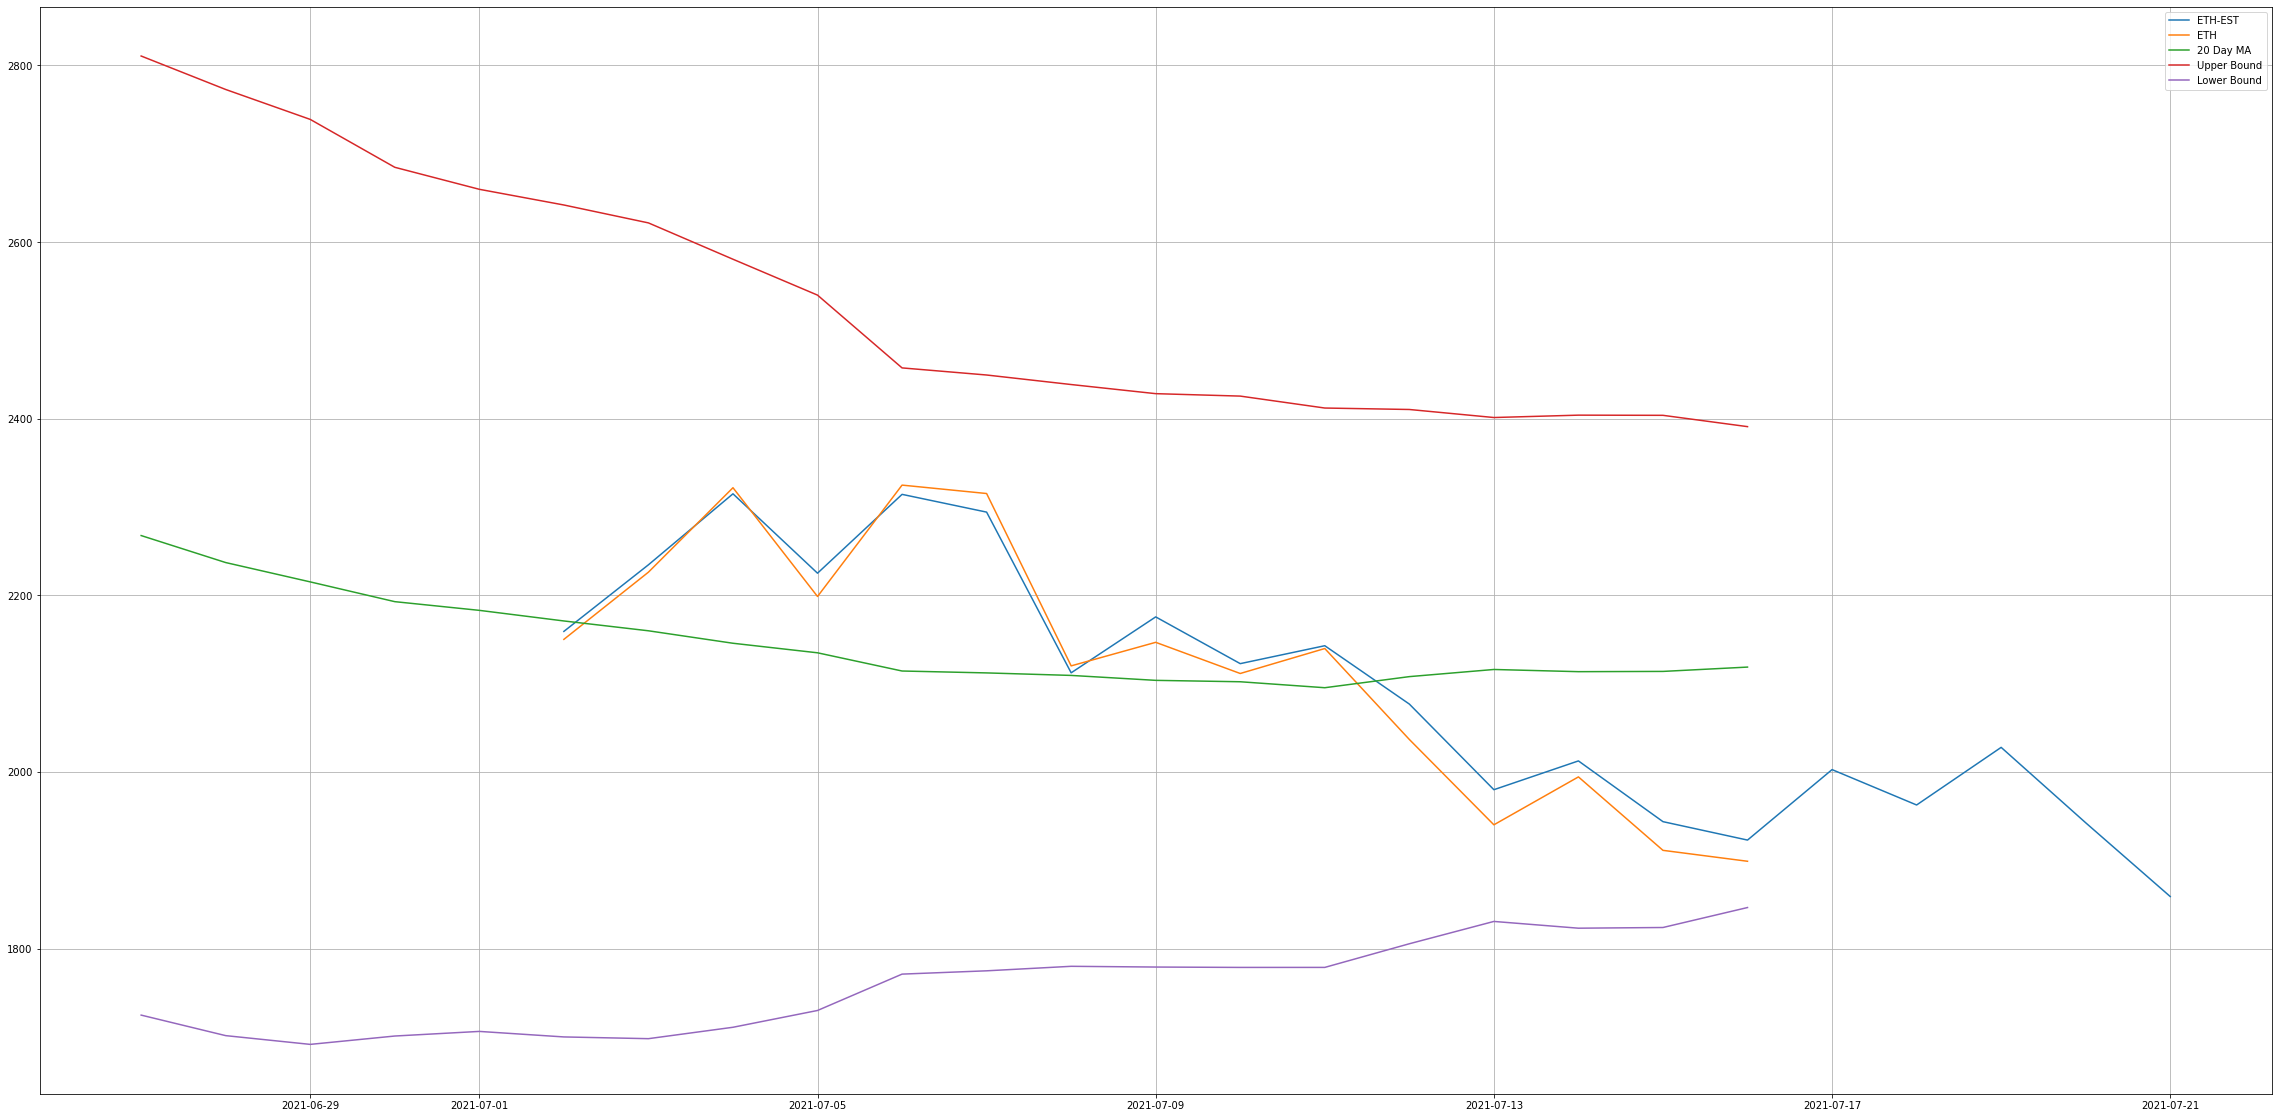

In [3409]:
fig = plt.figure(figsize=(40,20))
plt.plot(x, y_predict, label='ETH-EST')
# plt.plot(x, y_true, label='ETH')
plt.plot(x, y_forecast, label='ETH')
plt.plot(x, y_ma, label='20 Day MA')
plt.plot(x, y_upper, label='Upper Bound')
plt.plot(x, y_lower, label='Lower Bound')        
plt.legend()
plt.grid(True)
plt.show()

In [3410]:
crypto.tail()

,date,open,high,low,close,volume,next_close_5,ma20,upper,lower,predicted_close
20,2021-07-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002.583252
21,2021-07-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1962.529175
22,2021-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2027.762329
23,2021-07-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1942.390503
24,2021-07-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1858.868896
